# Regession

The goal of this notebook is to make a time series regression for annual total days, # events, intensity, duration, severity, etc. at the global scale, regional, country and city level

#### Dependencie

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns

#### Files

In [2]:
DATA_IN = "/home/cascade/projects/data_out_urbanheat/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FN = 'All_data20191109_final.csv'
df = pd.read_csv(DATA_IN+FN)
FIG_OUT = '/home/cascade/projects/figures/'

# open GHS-UCDB
ghs = gpd.read_file('/home/cascade/tana-crunch-cascade/projects/UrbanHeat/data/raw/GHS_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp')


In [3]:
df.head()

,Unnamed: 0,CTR_MN_NM,Event_ID,GCPNT_LAT,GCPNT_LON,ID_HDC_G0,avg_intensity,avg_temp,duration,event_dates,intensity,intermediate-region,region,sub-region,tmax,tot_intensity,total_days,year,start_date
0,0,Germany,1,48.138002,11.563435,2784,3.859750,44.459750,1,['1983.07.27'],[3.85975],Western Europe,Europe,Western Europe,[44.45975],3.859750,1,1983,1983.07.27
1,1,Germany,763005,48.138002,11.563435,2784,0.058337,40.658337,1,['2013.08.06'],[0.058337],Western Europe,Europe,Western Europe,[40.658337],0.058337,1,2013,2013.08.06
2,2,Germany,4,47.849642,12.102591,2833,6.893180,47.493180,1,['1983.07.27'],[6.89318],Western Europe,Europe,Western Europe,[47.49318],6.893180,1,1983,1983.07.27
3,3,Germany,22703,47.849642,12.102591,2833,1.187350,41.787350,1,['1984.07.11'],[1.18735],Western Europe,Europe,Western Europe,[41.78735],1.187350,1,1984,1984.07.11
4,4,Germany,349979,47.849642,12.102591,2833,0.793425,41.393425,1,['1998.08.11'],[0.793425],Western Europe,Europe,Western Europe,[41.393425],0.793425,1,1998,1998.08.11


In [4]:
# Add Severity
df['severity'] = df['tot_intensity'] * df['duration']


In [5]:
# Get populuations and area

df_pop = pd.DataFrame()
df_pop['ID_HDC_G0'] = ghs['ID_HDC_G0']
df_pop['AREA'] = ghs['AREA']
df_pop['P75'] = ghs['P75']
df_pop['P90'] = ghs['P90']
df_pop['P00'] = ghs['P00']
df_pop['P15'] =  ghs['P15']
df_pop['P15_wgt'] = ghs['P15'] / ghs['P15'].sum()
df_pop['AREA_wgt'] = ghs['AREA'] / ghs['AREA'].sum()
df_pop['geometry'] = ghs['geometry']

df_pop.head(1)

,ID_HDC_G0,AREA,P75,P90,P00,P15,P15_wgt,AREA_wgt,geometry
0,5782,23,76680.40387,77349.278442,75261.170776,69023.903442,0.00002,0.000035,"POLYGON ((88.1393063460871 69.36230222917577, ..."


In [6]:
df = df.merge(df_pop, on = 'ID_HDC_G0', how = 'inner')

In [7]:
df.head()

,Unnamed: 0,CTR_MN_NM,Event_ID,GCPNT_LAT,GCPNT_LON,ID_HDC_G0,avg_intensity,avg_temp,duration,event_dates,...,start_date,severity,AREA,P75,P90,P00,P15,P15_wgt,AREA_wgt,geometry
0,0,Germany,1,48.138002,11.563435,2784,3.859750,44.459750,1,['1983.07.27'],...,1983.07.27,3.859750,349,883145.629391,1.097815e+06,1.307097e+06,1.573652e+06,0.000445,0.000529,"POLYGON ((11.46764478885785 48.24059688257268,..."
1,1,Germany,763005,48.138002,11.563435,2784,0.058337,40.658337,1,['2013.08.06'],...,2013.08.06,0.058337,349,883145.629391,1.097815e+06,1.307097e+06,1.573652e+06,0.000445,0.000529,"POLYGON ((11.46764478885785 48.24059688257268,..."
2,2,Germany,4,47.849642,12.102591,2833,6.893180,47.493180,1,['1983.07.27'],...,1983.07.27,6.893180,25,58618.272278,6.147326e+04,6.477523e+04,6.497856e+04,0.000018,0.000038,"POLYGON ((12.10738143594193 47.87351619009313,..."
3,3,Germany,22703,47.849642,12.102591,2833,1.187350,41.787350,1,['1984.07.11'],...,1984.07.11,1.187350,25,58618.272278,6.147326e+04,6.477523e+04,6.497856e+04,0.000018,0.000038,"POLYGON ((12.10738143594193 47.87351619009313,..."
4,4,Germany,349979,47.849642,12.102591,2833,0.793425,41.393425,1,['1998.08.11'],...,1998.08.11,0.793425,25,58618.272278,6.147326e+04,6.477523e+04,6.497856e+04,0.000018,0.000038,"POLYGON ((12.10738143594193 47.87351619009313,..."


In [10]:
# Make Years List
years = np.unique(df['year'])
years

array([1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016])

In [11]:
# styles
kwargs = {'linewidth':0.7, 'marker': 'o'} #linestyle: '--'

# What is the slope of the heat wave characteristics over time?

In [ ]:
data = df.groupby(['year'])['duration'].mean()
plt.plot(data)
sns.regplot(years, data, color = 'blue')

plt.title('Global Duration')

In [ ]:
data = df.groupby(['year'])['tot_intensity'].mean()
plt.plot(data)
sns.regplot(years, data, color = 'blue')
plt.title('Global Intensity')

In [ ]:
data = df.groupby(['year'])['severity'].mean()
plt.plot(data)
sns.regplot(years, data, color = 'blue')
plt.title('Global Severity')

In [ ]:
data = df.groupby(['year'])['tot_intensity'].count()
plt.plot(data)
sns.regplot(years, data, color = 'blue')
plt.title('Global Frequency per Year')

In [ ]:
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
plt.plot(data)
sns.regplot(years, data, color = 'blue')
plt.title('Global Total Days per year >40.6C')

In [ ]:
#### All stacked

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize = (10,16), sharex=True)
fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration
data = df.groupby(['year'])['duration'].mean()
ax1.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax1)
ax1.set_title('Mean Duration')
ax1.set_ylabel('Consecutive Days')

# Mean Intensity
data = df.groupby(['year'])['tot_intensity'].mean()
ax2.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax2)
ax2.set_title('Mean Intensity')
ax2.set_ylabel('Degrees C > 40.6C')

# Mean Severity 
data = df.groupby(['year'])['severity'].mean()
ax3.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax3)
ax3.set_title('Mean Severity')
ax3.set_ylabel('Duration x Intensity')

# Total Number of Events 
data = df.groupby(['year'])['tot_intensity'].count()
ax4.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax4)
ax4.set_title('Total Frequency per Year')
ax4.set_ylabel('Number of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
ax5.plot(data)
sns.regplot(years, data, color = 'blue', ax = ax5)
ax5.set_title('Global Total Days per year >40.6C')
ax5.set_ylabel('Days Per Year')
ax5.set_xlabel('Year')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
# plt.savefig(FIG_OUT+'Fig1_v1')

# What are the trends by region?

In [ ]:
regions = np.unique(df['sub-region'])
for region in regions:
    print(region)

In [ ]:
data_list = []

for region in regions:
    data = df[df['sub-region'] == region]
    
    # Counts Days
#     data = data.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
#     data = data.groupby('year')['total_days'].sum()
    
    # Avgs
    #data = data.groupby('year')['severity'].mean()
    
    # Wgt-ed avts
    data = data.groupby('year').apply(lambda x: np.average(x['severity'], weights=x['P15']))
    
    # Population
    
    data_list.append(data)

In [ ]:
# Make subplots axes
fig, axs = plt.subplots(7,2, figsize=(8, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

color = 'Orange'

# Get subplot axes list
axs = axs.ravel()

for i in range(14):
    axs[i].title.set_text(regions[i])
    axs[i].plot(data_list[i], color = color)
    if len(data_list[i]) > 2:
        years = data_list[i].index
        data = list(data_list[i])
        sns.regplot(years, data, color = color, ax = axs[i])

# Plot details       
# plt.tight_layout()
# plt.subplots_adjust(top=0.85)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Annual Avg. Severity of Urban Extreme Heat Events 1983 - 2016', fontsize=16)

#plt.savefig(FIG_OUT+'Region-Freq.png')

In [ ]:
data_list[2]

#### Frequency by region

In [ ]:
# plot by region 
ylabel = 'Frequency of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['ID_HDC_G0'].count()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Duration by region

In [ ]:
# plot by region 
ylabel = 'Annual average duration of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['duration'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Severity by region

In [ ]:
# plot by region 
ylabel = 'Annual average severity of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['severity'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Annual average severity of heat waves per year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Intensity by region

In [ ]:
# plot by region 
ylabel = 'Annual average total intensity of heat waves per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.groupby('year')['tot_intensity'].mean()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Annual average total intensity of heat waves per year', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)
#plt.ylabel('Number of Heat Waves', fontsize = 15)

#### Days per year by region

In [ ]:
# plot by region 
ylabel = 'Avg number of days per year'

fig, ax = plt.subplots(figsize=(8,6))
labels = []
for label, df_c in df.groupby('sub-region'):
    data = df_c.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
    data = data.groupby('year')['total_days'].sum()
    labels.append(label)
    plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Avg total of days per year Tmax >40.6C by city', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)


# Check regions individually

In [ ]:
# plot by region 
ylabel = 'Days per year >40.6C'
geog = 'sub-region'
region = 'Sub-Saharan Africa'

fig, ax = plt.subplots(figsize=(8,6))
labels = [region]
data = df[df[geog] == region]
data = data.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
# data = data.groupby('year')['avg_temp'].count()
labels.append(region)
plt.plot(data, alpha = 0.9)

plt.legend(labels, bbox_to_anchor=(1.04,1), loc="upper left", fontsize = 15)
plt.title('Total of heat wave events of Heat Waves', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.ylabel(ylabel, fontsize = 15)

# Plots by each event start date

In [ ]:
india = df[df['CTR_MN_NM'] == 'India']

In [ ]:
y = india['duration']
x = pd.to_datetime(india['start_date'])

In [ ]:
plt.scatter(x,y, alpha = 0.1)

# Population and Area Weighted Totals
see: https://pbpython.com/weighted-average.html

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Duration')
plt.ylabel('Duration (days)')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Intensity')
plt.ylabel('Sum Tmax > 40.6C')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Severity')
plt.ylabel('Duration x Tot. Intensity')

In [ ]:
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['P15']))
plt.plot(data, **kwargs)
plt.title('Global Populuation-Weighted Avg. Temp')
plt.ylabel('Degrees C')

In [ ]:
# Weighted count num of events by pop

data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

# get pop weights
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['P15_wgt']
print(len(data))

## plot it 
data = data.groupby('year')['count_wgt'].sum()
plt.plot(data, **kwargs)
plt.title('Global Population-Weighted Frequency per Year')
plt.ylabel('Population-weighted Frequency of Events')


In [ ]:
# Weighted number of days num of events by pop

data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['P15_wgt'] # calc day weights

## plot it 
data = data.groupby('year')['days_wgt'].sum()
plt.plot(data, **kwargs)
plt.title('Global Population-Weighted Tot Number of Days per year >40.6')
plt.ylabel('Population-weighted Num of \n Days per year >40.6c')

# All plots in one

In [ ]:
#### All stacked no weights

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (10,16), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration
data = df.groupby(['year'])['duration'].mean()
ax1.plot(data, **kwargs)
ax1.set_title('Mean Duration')
ax1.set_ylabel('Consecutive Days')

# Mean Intensity
data = df.groupby(['year'])['tot_intensity'].mean()
ax2.plot(data, **kwargs)
ax2.set_title('Mean Intensity')
ax2.set_ylabel('Degrees C > 40.6C')

# Mean Temp
data = df.groupby(['year'])['avg_temp'].mean()
ax3.plot(data, **kwargs)
ax3.set_title('Mean Tempature')
ax3.set_ylabel('Degrees C > 40.6C')

# Mean Severity 
data = df.groupby(['year'])['severity'].mean()
ax4.plot(data, **kwargs)
ax4.set_title('Mean Severity')
ax4.set_ylabel('Duration x Intensity')

# Total Number of Events 
data = df.groupby(['year'])['tot_intensity'].count()
ax5.plot(data, **kwargs)
ax5.set_title('Total Frequency per Year')
ax5.set_ylabel('Number of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
data = data.groupby('year')['total_days'].sum()
ax6.plot(data, **kwargs)
ax6.set_title('Global Total Days per year >40.6C')
ax6.set_ylabel('Days Per Year')
ax6.set_xlabel('Year')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
#plt.savefig(FIG_OUT+'Fig1_v1_nowgt')

In [ ]:
axs[0][0]

In [ ]:
#### All stacked pop weights

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,15), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

years = np.unique(df['year'])

# Mean Duration
data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['P15']))
ax1.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax1)

ax1.set_title('Global Populuation-Weighted Avg. Duration', fontsize = 15)
ax1.set_ylabel('Duration (days)', fontsize = 15)

# Mean Intensity
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['P15']))
ax2.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax2)
ax2.set_title('Global Populuation-Weighted Avg. Intensity', fontsize = 15)
ax2.set_ylabel('Sum Tmax > 40.6C', fontsize = 15)

# Mean Temp
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['P15']))
ax3.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax3)
ax3.set_title('Global Populuation-Weighted Avg. Temp', fontsize = 15)
ax3.set_ylabel('Avg Temp C', fontsize = 15)


# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
plt.savefig(FIG_OUT+'Fig1_1_popwgt')

In [ ]:
#### All stacked pop weights

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,15), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

years = np.unique(df['year'])

# Mean Severity 
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['P15']))
ax1.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax1)
ax1.set_title('Global Populuation-Weighted Avg. Severity', fontsize = 15)
ax1.set_ylabel('Duration x Tot. Intensity', fontsize = 15)

# Total Number of Events 
data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

wgt = df_pop[['ID_HDC_G0', 'P15_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['P15_wgt']

data = data.groupby('year')['count_wgt'].sum()
ax2.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax2)
ax2.set_title('Global Population-Weighted Frequency per Year', fontsize = 15)
ax2.set_ylabel('Population-weighted \n Frequency of Events', fontsize = 15)

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'P15_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['P15_wgt'] # calc day weights


data = data.groupby('year')['days_wgt'].sum()
ax3.plot(data, **kwargs, color = 'Green')
sns.regplot(years, data, color = 'Green', ax = ax3)
ax3.set_title('Global Population-Weighted Tot Number of Days per year >40.6', fontsize = 15)
ax3.set_ylabel('Population-weighted Num of \n Days per year >40.6c', fontsize = 15)

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()

plt.savefig(FIG_OUT+'Fig1_2_popwgt')

In [ ]:
#### All stacked area weights

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize = (10,16), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Mean Duration

data = df.groupby(['year']).apply(lambda x: np.average(x['duration'], weights=x['AREA']))
ax1.plot(data, **kwargs, color = 'Red')
ax1.set_title('Global Populuation-Weighted Avg. Duration')
ax1.set_ylabel('Duration (days)')

# Mean Intensity
data = df.groupby(['year']).apply(lambda x: np.average(x['tot_intensity'], weights=x['AREA']))
ax2.plot(data, **kwargs, color = 'Red')
ax2.set_title('Global Populuation-Weighted Avg. Intensity')
ax2.set_ylabel('Sum Tmax > 40.6C')

# Mean Temp
data = df.groupby(['year']).apply(lambda x: np.average(x['avg_temp'], weights=x['AREA']))
ax3.plot(data, **kwargs, color = 'Red')
ax3.set_title('Global Populuation-Weighted Avg. Temp')
ax3.set_ylabel('Avg Temp C')

# Mean Severity 
data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['AREA']))
ax4.plot(data, **kwargs, color = 'Red')
ax4.set_title('Global Populuation-Weighted Avg. Severity')
ax4.set_ylabel('Duration x Tot. Intensity')

# Total Number of Events 
data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

wgt = df_pop[['ID_HDC_G0', 'AREA_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['AREA_wgt']

data = data.groupby('year')['count_wgt'].sum()
ax5.plot(data, **kwargs, color = 'Red')
ax5.set_title('Global Population-Weighted Frequency per Year')
ax5.set_ylabel('Population-weighted \n Frequency of Events')

# Total Number of Days Per Year 
data = df.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first') # drop out duplicates
data = data[['ID_HDC_G0', 'year', 'total_days']] # Get Data
wgt = df_pop[['ID_HDC_G0', 'AREA_wgt']] # Get pop weights
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner') # merge
data['days_wgt'] = data['total_days'] * data['AREA_wgt'] # calc day weights


data = data.groupby('year')['days_wgt'].sum()
ax6.plot(data, **kwargs, color = 'Red')
ax6.set_title('Global Population-Weighted Tot Number of Days per year >40.6')
ax6.set_ylabel('Population-weighted Num of \n Days per year >40.6c')

# Set year axes
for ax in fig.get_axes():
    ax.label_outer()
    
# Fig save
#plt.savefig(FIG_OUT+'Fig1_v1_areawgt')

# AGU 2019 Plots

### Global

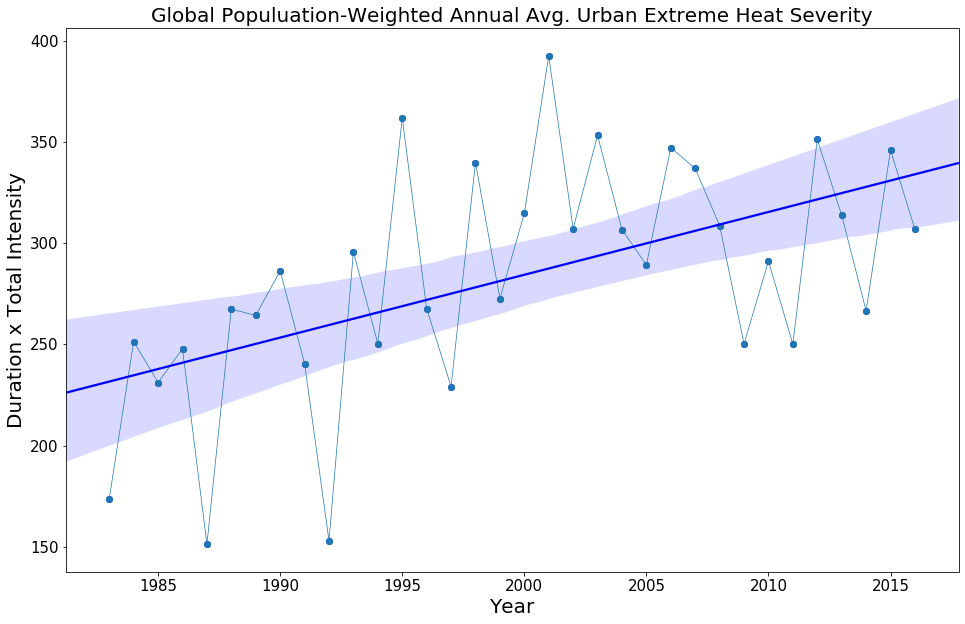

In [36]:
# Severity


fig, (ax1) = plt.subplots(1, figsize = (16,10), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

data = df.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['P15']))
ax1.plot(data, **kwargs)
sns.regplot(years, data, color = 'Blue', ax = ax1)
ax1.set_title('Global Populuation-Weighted Annual Avg. Urban Extreme Heat Severity', fontsize = 20)
ax1.set_ylabel('Duration x Total Intensity', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)
plt.savefig(FIG_OUT+'AGU_Global_Sev.png')

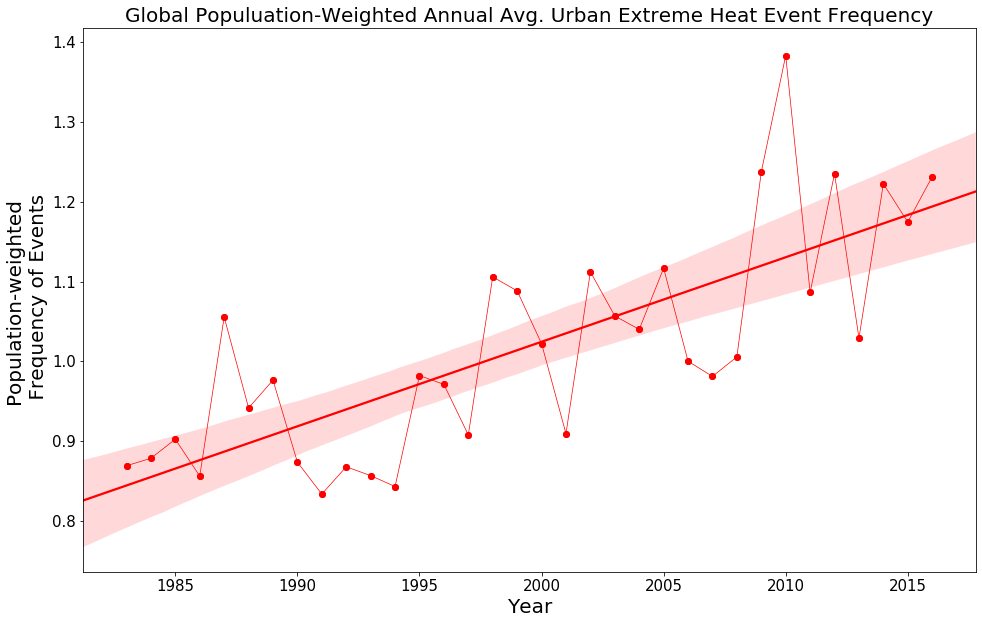

In [38]:

fig, (ax1) = plt.subplots(1, figsize = (16,10), sharex=True)
#fig.suptitle('Characteristics of Urban Extreme Heat Events Globally 1983 - 2016')

# Total Number of Events 
data = pd.DataFrame(df.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

wgt = df_pop[['ID_HDC_G0', 'AREA_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['AREA_wgt']

data = data.groupby('year')['count_wgt'].sum()
ax1.plot(data, **kwargs, color = 'Red')
sns.regplot(years, data, color = 'Red', ax = ax1)
ax1.set_title('Global Populuation-Weighted Annual Avg. Urban Extreme Heat Event Frequency', fontsize = 20)
ax1.set_ylabel('Population-weighted \n Frequency of Events', fontsize = 20)
ax1.set_xlabel('Year', fontsize = 20)
ax1.tick_params(labelsize = 15)

plt.savefig(FIG_OUT+'AGU_Global_Freq.png')

### Regions

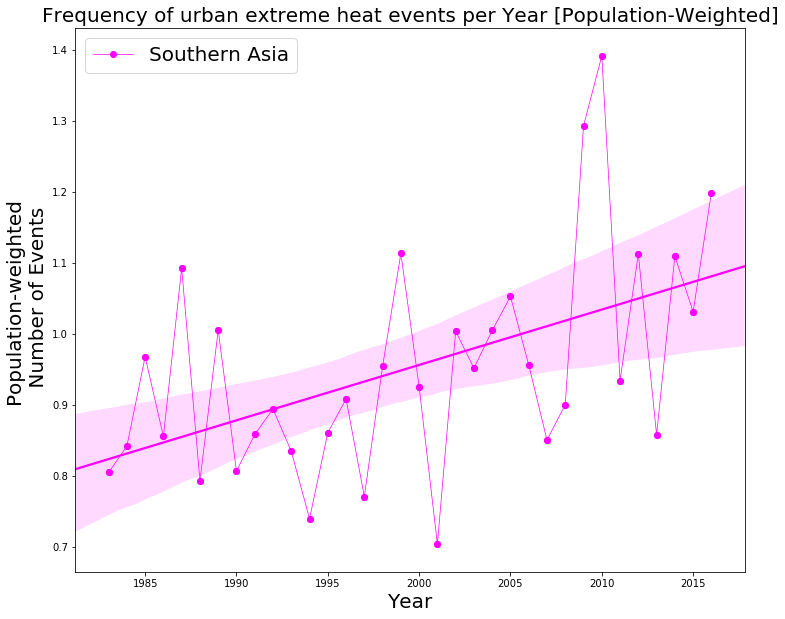

In [114]:
# plot by region 
ylabel = 'Number of events'
geog = 'sub-region'
region = 'Southern Asia'
color = 'fuchsia'
fn = 'AGU_SA_Freq.png'

fig, ax = plt.subplots(figsize=(12,10))
labels = [region]
data = df[df[geog] == region]

#data = data.drop_duplicates(['year', 'ID_HDC_G0'], keep = 'first')
#data = data.groupby(['year']).apply(lambda x: np.average(x['severity'], weights=x['P15']))
#data = data.groupby('year')['duration'].mean()

# plt.title('Mean severity of urban extreme heat events [Population Weighted]', fontsize = 20)
# plt.xlabel('Year', fontsize = 20)
# plt.ylabel('Duration x Total Intensity', fontsize = 20)
# plt.tick_params(labelsize = 15)

# Total Number of Events 
data = pd.DataFrame(data.groupby(['year', 'ID_HDC_G0'])['tot_intensity'].count()) # group by year and then ID and count
data = data.swaplevel() # fix the levels
data.reset_index(level=['year', 'ID_HDC_G0'], inplace=True) # reset index
data.rename(columns={'tot_intensity':'event_counts'}, inplace=True) # rename

wgt = df_pop[['ID_HDC_G0', 'P15_wgt']]
data = pd.merge(data, wgt, on = 'ID_HDC_G0', how = 'inner')
data['count_wgt'] = data['event_counts'] * data['P15_wgt']

data = data.groupby('year')['count_wgt'].sum()
plt.plot(data, **kwargs, color = color)
plt.legend(labels, fontsize = 20) #bbox_to_anchor=(1.04,1), loc="upper left", 
sns.regplot(years, data, color = color)
plt.title('Frequency of urban extreme heat events per Year [Population-Weighted]', fontsize = 20)
plt.ylabel('Population-weighted \n Number of Events', fontsize = 20)
plt.xlabel('Year', fontsize = 20)


plt.savefig(FIG_OUT+fn)

# Regessions

-- double check this

In [201]:
from numpy.polynomial.polynomial import polyfit

# make things easier for OLS
regressor = LinearRegression()  

# Geog 
geog = 'CTR_MN_NM'

# Set stat
stats = 'severity'

# Get results

labels = []
r2_list = []
coef_list = []
p_list = []
df_out = pd.DataFrame()

for label, df_c in df.groupby(geog):
    
    # Get Data
    X_year = np.array(df_c.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df_c.groupby('year')[stats].mean()).reshape((-1, 1))
    
    # Regress
    model = sm.OLS(Y_stats, X_year).fit()
    coef = model.params[0]
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    # Make lists
    labels.append(label)
    r2_list.append(r2)
    coef_list.append(coef)
    p_list.append(p)
#     print(label)
#     print(model.summary())
    
# Make data frame
df_out[geog] = labels
df_out['r2'] = r2_list
df_out['coef'] = coef_list
df_out['p_value'] = [round(elem, 4) for elem in p_list]

/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1648: RuntimeWarning: invalid value encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/home/cascade/miniconda3/envs/geo/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1578: RuntimeWarning: divide by zero 

In [202]:
print('Reg. results for average annual', stats, 'by year 1983 - 2016')
df_out.sort_values(by = 'coef', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(50)


Reg. results for average annual severity by year 1983 - 2016


,CTR_MN_NM,r2,coef,p_value
49,Iraq,0.862936,1.337439,0.0000
58,Kuwait,0.703439,1.268601,0.0000
48,Iran,0.940056,0.553344,0.0000
80,Pakistan,0.859862,0.201893,0.0000
91,Saudi Arabia,0.781475,0.153443,0.0000
2,Algeria,0.960892,0.136163,0.0000
21,Chad,0.816321,0.130217,0.0000
29,Djibouti,0.658521,0.102328,0.0000
115,United Arab Emirates,0.677055,0.100896,0.0000
102,Sudan,0.806518,0.096415,0.0000


In [203]:
# Get top 500 cities
city_sort = df_out.sort_values(by = 'coef', axis=0, 
                               ascending=False, inplace=False, kind='quicksort', na_position='last').head(1000)


In [171]:
len(city_sort)

1000

In [175]:
ghs.columns

Index(['ID_HDC_G0', 'QA2_1V', 'AREA', 'BBX_LATMN', 'BBX_LONMN', 'BBX_LATMX',
       'BBX_LONMX', 'GCPNT_LAT', 'GCPNT_LON', 'CTR_MN_NM',
       ...
       'EX_SS_P00', 'EX_SS_P15', 'EX_EQ19PGA', 'EX_EQ19MMI', 'EX_EQ19_Q',
       'EX_HW_IDX', 'SDG_LUE901', 'SDG_A2G14', 'SDG_OS15MX', 'geometry'],
      dtype='object', length=161)

In [182]:
city_sort = city_out.merge(ghs[['geometry', 'ID_HDC_G0',
                                'GCPNT_LAT', 'GCPNT_LON']], on = 'ID_HDC_G0', how = 'inner')

In [177]:
city_sort.head()

,ID_HDC_G0,r2,coef,p_value,geometry,GCPNT_LAT,GCPNT_LON
0,5712,0.739035,8.201320,0.0,"POLYGON ((48.72944621720129 31.3803500920224, ...",31.309773,48.674817
1,5722,0.702822,6.503086,0.0,"POLYGON ((48.62125455909589 30.65989126407588,...",30.649491,48.660247
2,5683,0.703382,5.104692,0.0,"POLYGON ((48.1736807075098 31.56938483107773, ...",31.556492,48.186064
3,5703,0.723197,4.969857,0.0,"POLYGON ((48.14423201464125 30.46297873607696,...",30.437306,48.179071
4,5749,0.758831,4.876542,0.0,"POLYGON ((49.18566336869166 30.57425855300352,...",30.551954,49.182376


In [184]:
#city_sort.to_csv(DATA_IN+'City_1000SeverCoef.csv')

In [204]:
country_sort = df_out.sort_values(by = 'coef', axis=0, 
                                  ascending=False, inplace=False, kind='quicksort', na_position='last').head(10)


In [205]:
country_sort.head(10)

,CTR_MN_NM,r2,coef,p_value
49,Iraq,0.862936,1.337439,0.0
58,Kuwait,0.703439,1.268601,0.0
48,Iran,0.940056,0.553344,0.0
80,Pakistan,0.859862,0.201893,0.0
91,Saudi Arabia,0.781475,0.153443,0.0
2,Algeria,0.960892,0.136163,0.0
21,Chad,0.816321,0.130217,0.0
29,Djibouti,0.658521,0.102328,0.0
115,United Arab Emirates,0.677055,0.100896,0.0
102,Sudan,0.806518,0.096415,0.0


In [206]:
countries = gpd.read_file(DATA_IN+'Countries_WGS84.shp')
countries.head()

,OBJECTID,CNTRY_NAME,geometry
0,1,Aruba,"POLYGON ((-69.8822326660156 12.4111099243165, ..."
1,2,Antigua and Barbuda,"(POLYGON ((-61.7388916015625 17.5405540466309,..."
2,3,Afghanistan,"POLYGON ((61.2765579223633 35.6072463989258, 6..."
3,4,Algeria,"POLYGON ((-5.15213489532459 30.1804695129396, ..."
4,5,Azerbaijan,"(POLYGON ((45.0258293151855 41.0305480957031, ..."


In [207]:
countries.rename(columns={'CNTRY_NAME': 'CTR_MN_NM'}, inplace=True)
country_sort = country_sort.merge(countries[['CTR_MN_NM', 'geometry']], on = 'CTR_MN_NM', how = 'inner')
country_sort.head()

,CTR_MN_NM,r2,coef,p_value,geometry
0,Iraq,0.862936,1.337439,0.0,"POLYGON ((39.1967430114746 32.154941558838, 39..."
1,Kuwait,0.703439,1.268601,0.0,"(POLYGON ((47.4633941650391 28.9844646453857, ..."
2,Iran,0.940056,0.553344,0.0,"(POLYGON ((60.8069381713867 31.9966621398927, ..."
3,Pakistan,0.859862,0.201893,0.0,"POLYGON ((63.2304382324219 29.4736976623535, 6..."
4,Saudi Arabia,0.781475,0.153443,0.0,"(POLYGON ((51.2152252197266 18.8215637207031, ..."


In [209]:
#gpd.GeoDataFrame(country_sort).to_file(DATA_IN+'Ctr10_SeverCoef.shp')

# Old Reg Code

In [ ]:
df_out_merge = df_out.merge(df, on = 'ID_HDC_G0', how = 'inner')
df_out_merge = df_out_merge.drop_duplicates('ID_HDC_G0')

In [ ]:
df_out_merge.sort_values(by = 'coef', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(50)


In [ ]:
data = df[df[geog] == 'Iraq']
year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))

In [ ]:
plt.plot(year, stats, **kwargs)

In [ ]:
# Get Data
X_year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))
    

In [ ]:
plt.plot(X_year, Y_stats)

In [ ]:
model = sm.OLS(Y_stats, X_year).fit()

model.params

In [ ]:
df_out_merge = df_out.merge(df, on = 'ID_HDC_G0', how = 'inner')
df_out_merge = df_out_merge.drop_duplicates('ID_HDC_G0')

In [ ]:
df_out_merge.sort_values(by = 'coef', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(50)


In [ ]:
data = df[df[geog] == 'Iraq']
year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))

In [ ]:
plt.plot(year, stats, **kwargs)

In [ ]:
# Get Data
X_year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))
    

In [ ]:
plt.plot(X_year, Y_stats)

In [ ]:
model = sm.OLS(Y_stats, X_year).fit()

model.params

In [ ]:
df_out_merge = df_out.merge(df, on = 'ID_HDC_G0', how = 'inner')
df_out_merge = df_out_merge.drop_duplicates('ID_HDC_G0')

In [ ]:
df_out_merge.sort_values(by = 'coef', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last').head(50)


In [ ]:
data = df[df[geog] == 'Iraq']
year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))

In [ ]:
plt.plot(year, stats, **kwargs)

In [ ]:
# Get Data
X_year = np.array(data.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(data.groupby('year')['severity'].mean()).reshape((-1, 1))
    

In [ ]:
plt.plot(X_year, Y_stats)

In [ ]:
model = sm.OLS(Y_stats, X_year).fit()

model.params